In [1]:
from collections import OrderedDict
des = ['cycles','instructions','insn','cache-references','cache-misses'
       ,'bus-cycles','L1-dcache-loads','L1-dcache-load-misses'
       ,'L1-dcache-stores','dTLB-loads','dTLB-load-misses']
def create_field(filename):
    file = open(filename).read().split()
    s = OrderedDict()
    for i,val in enumerate(file):
        s[val] = i
    fields = {}
    for val in des:
        if val not in s.keys() or file[s[val]-1] == 'counted>': 
            return 0
        else :
            fields[val] = float(file[s[val]-1].replace(',',''))
    cnt = 0
    for i,word in enumerate(file):
        if word == 'seconds':
            fields[word+str(cnt)] = float(file[i-1])
            cnt = cnt+1
    chk = []
    for i,word in enumerate(file):
        if word == 'of':
            chk.append(i)
        
    fields['cache-miss-per'] = float(file[chk[0]-2])
    fields['L1-dcache-miss-per'] = float(file[chk[1]-1].replace('%',''))
    fields['dTLB-miss-per'] = float(file[chk[2]-1].replace('%',''))
    
    return fields

In [2]:
import os

In [3]:
normal = 'train_data/Normal'
meltdown = 'train_data/Meltdown'
rowhammer = 'train_data/ROWHAMMER'

In [4]:
all_fields = ['cycles', 'instructions', 'insn', 'cache-references'
              , 'cache-misses', 'bus-cycles', 'L1-dcache-loads'
              , 'L1-dcache-load-misses', 'L1-dcache-stores', 'dTLB-loads'
              , 'dTLB-load-misses', 'seconds0', 'seconds1', 'seconds2'
              , 'seconds3', 'seconds4', 'seconds5', 'seconds6', 'seconds7'
              , 'seconds8', 'cache-miss-per', 'L1-dcache-miss-per', 'dTLB-miss-per']

In [5]:
def gen(name):
    dirs1 = os.listdir(name)
    res = {}
    for dirs in dirs1:
        lev1 = os.path.join(name,dirs)
        contents = os.listdir(lev1)
        here = {val:[] for val in all_fields}
        for fil in contents:
            fields = create_field(os.path.join(lev1,fil))
            if fields == 0:
                continue
            for k in all_fields:
                here[k].append(fields[k])

        res[dirs] = here
    return res

In [6]:
import pandas as pd
import numpy as np

In [7]:
mb = gen(normal)
md = gen(meltdown)
rhm = gen(rowhammer)

In [8]:
def modify(program,fname):
    df = pd.DataFrame.from_dict(program[fname])
    fst = ['cycles', 'instructions', 'cache-references', 'cache-misses',
       'bus-cycles',]
    snd = ['L1-dcache-loads', 'L1-dcache-load-misses',
       'L1-dcache-stores']
    thd = ['dTLB-loads', 'dTLB-load-misses']
    
    for k in fst:
        df[k] = np.log10(df[k]/df['seconds0'])
    for k in snd:
        df[k] = np.log10(df[k]/df['seconds3'])
    for k in thd:
        df[k] = np.log10(df[k]/df['seconds6'])
      
    return df

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def plot_util(name, f, ftr):
    return modify(f,name+'large')[ftr]

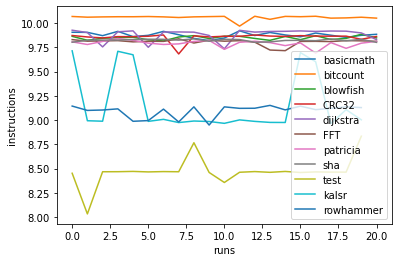

In [44]:
ftr = 'instructions'
lst = ['basicmath', 'bitcount', 'blowfish', 'CRC32', 'dijkstra', 'FFT', 'patricia','sha']
for l in lst:
    plt.plot(plot_util(l,mb,ftr), label=l)
plt.plot(modify(md,'test')[ftr][:20], label= 'test')
plt.plot(modify(md,'kalsr')[ftr][:20], label= 'kalsr')
plt.plot(modify(rhm,'rowhammer')[ftr][:20],label = 'rowhammer')
plt.legend()
plt.xlabel('runs')
plt.ylabel(ftr)
plt.show()

In [45]:
flds = ['cycles', 'instructions', 'cache-references', 'cache-misses',
       'bus-cycles','L1-dcache-loads', 'L1-dcache-load-misses',
       'L1-dcache-stores','dTLB-loads', 'dTLB-load-misses', 'cache-miss-per','L1-dcache-miss-per']
def preptrain(x,skip):
    train = {val:[] for val in flds}

    for key in x.keys():
        if key == 'stringsearchsmall' or key == 'stringsearchlarge':
            continue
        if key == 'quicksortsmall' or key == 'quicksortlarge':
            continue
        xx = modify(x,key)
        for fld in flds:
            if skip!=0:
                train[fld].extend(xx[fld][::skip])
            else :
                train[fld].extend(xx[fld])
    return pd.DataFrame.from_dict(train)

In [46]:
X_train = preptrain(mb,5)
X_train.shape

(80, 12)

In [47]:
X_train2 = preptrain(rhm,0)
X_train2.shape

(40, 12)

In [48]:
xt = X_train.append(X_train2)
xt.shape

(120, 12)

In [49]:
y_train = np.zeros(X_train.shape[0])
y_train2 = np.ones(X_train2.shape[0])

In [50]:
yt = np.append(y_train,y_train2,axis=0)
yt.shape

(120,)

In [51]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [52]:
test = SelectKBest(k=4)
fit = test.fit(xt, yt)

In [59]:
print(fit.scores_)

[2.51174333e+02 1.93367252e+03 8.09728357e+01 4.10889153e+02
 7.62132427e+00 4.46074877e+02 2.22166254e+02 3.60901969e+02
 5.46605067e+02 1.28837365e+01 8.55975201e+02 1.35918417e+04]


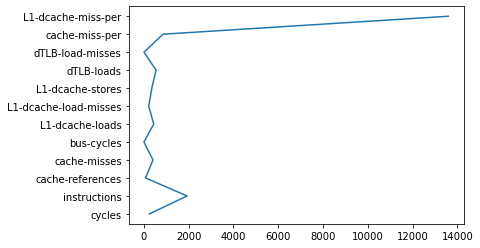

In [62]:
plt.plot(fit.scores_,flds)
plt.show()

In [147]:
xt['pred'] = yt

In [149]:
xt.to_csv('train_data.csv',index=False)

In [157]:
rhmtest = gen('train_data/ROWHAMMER_TEST')
rhmrtest = modify(rhmtest,'rowhammer')

In [158]:
train2 = {val:[] for val in flds}
for key in rhmtest.keys():
    for fld in flds:
        train2[fld].extend(rhmtest[key][fld])
        
topass = pd.DataFrame.from_dict(train2)
topass.shape

(10, 2)

In [159]:
topass.to_csv('rhmr_test.csv',index=False)